In [2]:
!pip install librosa matplotlib seaborn scikit-learn torch torchvision torchaudio
!pip install umap-learn

import torch
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import os
from google.colab import drive

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

drive.mount('/content/drive')

Using device: cuda
Mounted at /content/drive


Successfully loaded index 0: Pangarap
Sample Input Shape: torch.Size([1, 128, 128])
Sample Genre: rock


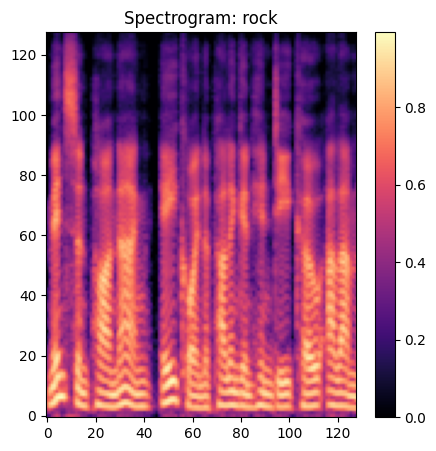

In [4]:
import os
import pandas as pd
import numpy as np
import librosa
import torch
from torch.utils.data import Dataset, DataLoader
import re
import matplotlib.pyplot as plt


CSV_PATH = '/content/drive/MyDrive/CSE425_Project/lyrics.csv'
AUDIO_DIR = '/content/drive/MyDrive/CSE425_Project/wav_files/'

SAMPLE_RATE = 22050
DURATION = 30
N_MELS = 128
FIXED_WIDTH = 128


class MusicDataset(Dataset):
    def __init__(self, csv_file, audio_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.audio_dir = audio_dir
        self.transform = transform

    def normalize_filename(self, track_name):
        """
        Converts 'Baby It's Cold Outside' -> 'baby_it_s_cold_outside_30s.wav'
        """
        name = str(track_name).lower()
        name = re.sub(r'[^a-z0-9]', '_', name)
        filename = f"{name}_30s.wav"
        return filename

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        row = self.data.iloc[idx]
        track_name = row['track_name']

        file_name = self.normalize_filename(track_name)
        audio_path = os.path.join(self.audio_dir, file_name)

        try:
            y, sr = librosa.load(audio_path, sr=SAMPLE_RATE, duration=DURATION)

            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS)
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)


            img = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min() + 1e-6)

            if img.shape[1] > FIXED_WIDTH:
                start = 0
                img = img[:, start:start+FIXED_WIDTH]
            else:
                pad_width = FIXED_WIDTH - img.shape[1]
                img = np.pad(img, ((0, 0), (0, pad_width)), mode='constant')

            img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0)

            return img_tensor, row['playlist_genre']

        except Exception as e:
            return torch.zeros((1, N_MELS, FIXED_WIDTH)), "error"

dataset = MusicDataset(csv_file=CSV_PATH, audio_dir=AUDIO_DIR)


sample_img = None
sample_label = None

for i in range(len(dataset)):
    img, label = dataset[i]
    if label != "error":
        sample_img = img
        sample_label = label
        print(f"Successfully loaded index {i}: {dataset.data.iloc[i]['track_name']}")
        break

if sample_img is not None:
    print(f"Sample Input Shape: {sample_img.shape}")
    print(f"Sample Genre: {sample_label}")

    # Visualize
    plt.figure(figsize=(5, 5))
    plt.imshow(sample_img.squeeze().numpy(), aspect='auto', origin='lower', cmap='magma')
    plt.title(f"Spectrogram: {sample_label}")
    plt.colorbar()
    plt.show()
else:
    print("Could not load any valid files. Check paths and filenames.")

# Create DataLoader
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

**Easy Task**

Starting Training...


/tmp/ipython-input-3337441526.py:62: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, sr=SAMPLE_RATE, duration=DURATION)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=118
  warnings.warn(


Epoch: 1 | Average Loss: 7749.3368
Epoch: 2 | Average Loss: 7156.8916
Epoch: 3 | Average Loss: 7022.2262
Epoch: 4 | Average Loss: 6827.0334
Epoch: 5 | Average Loss: 6774.8424
Epoch: 6 | Average Loss: 6754.5861
Epoch: 7 | Average Loss: 6745.4076
Epoch: 8 | Average Loss: 6786.2143
Epoch: 9 | Average Loss: 6784.6120
Epoch: 10 | Average Loss: 6719.9134
Epoch: 11 | Average Loss: 6706.5358
Epoch: 12 | Average Loss: 6711.1905
Epoch: 13 | Average Loss: 6709.6522
Epoch: 14 | Average Loss: 6684.1414
Epoch: 15 | Average Loss: 6666.2797
Epoch: 16 | Average Loss: 6654.8540
Epoch: 17 | Average Loss: 6643.1420
Epoch: 18 | Average Loss: 6632.7156
Epoch: 19 | Average Loss: 6622.5793
Epoch: 20 | Average Loss: 6614.2883


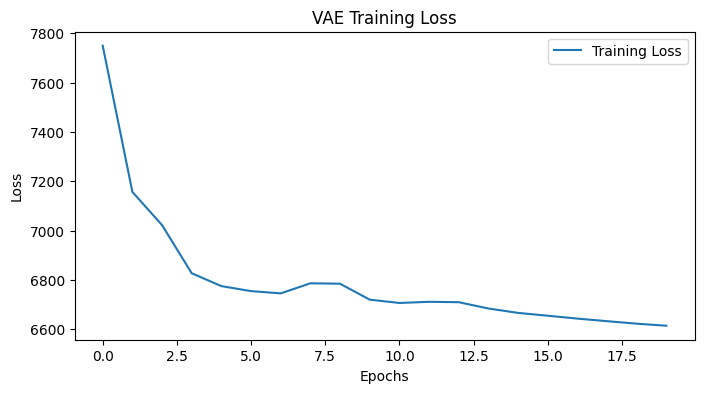

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


class VAE(nn.Module):
    def __init__(self, latent_dim=64):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # --- ENCODER ---
        # Input: (1, 128, 128)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # -> (32, 64, 64)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), # -> (64, 32, 32)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # -> (128, 16, 16)
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), # -> (256, 8, 8)
            nn.ReLU()
        )

        # Flatten size: 256 channels * 8 * 8 = 16384
        self.fc_mu = nn.Linear(256 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(256 * 8 * 8, latent_dim)

        # --- DECODER ---
        self.decoder_input = nn.Linear(latent_dim, 256 * 8 * 8)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), # -> (128, 16, 16)
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # -> (64, 32, 32)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # -> (32, 64, 64)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),    # -> (1, 128, 128)
            nn.Sigmoid() # Output pixels must be between 0 and 1
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encode
        h = self.encoder(x)
        h = h.view(h.size(0), -1) # Flatten
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)

        # Reparameterize
        z = self.reparameterize(mu, logvar)

        # Decode
        d = self.decoder_input(z)
        d = d.view(d.size(0), 256, 8, 8) # Unflatten
        reconstruction = self.decoder(d)

        return reconstruction, mu, logvar

# ==========================================
# 2. LOSS FUNCTION
# ==========================================
def loss_function(recon_x, x, mu, logvar):
    # 1. Reconstruction Loss (how closely does output match input?)
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # 2. KL Divergence (keeps latent space neat and tidy)
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

# ==========================================
# 3. TRAINING LOOP
# ==========================================
# Settings
LATENT_DIM = 64
EPOCHS = 20  # Start small to test
LEARNING_RATE = 1e-3

# Initialize Model
model = VAE(latent_dim=LATENT_DIM).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("Starting Training...")
model.train()
losses = []

for epoch in range(EPOCHS):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)

        optimizer.zero_grad()

        # Forward pass
        recon_batch, mu, logvar = model(data)

        # Calculate loss
        loss = loss_function(recon_batch, data, mu, logvar)

        # Backward pass
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    # Average loss for this epoch
    avg_loss = train_loss / len(train_loader.dataset)
    losses.append(avg_loss)
    print(f'Epoch: {epoch+1} | Average Loss: {avg_loss:.4f}')

# Plot Loss Curve
plt.figure(figsize=(8, 4))
plt.plot(losses, label='Training Loss')
plt.title("VAE Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Extracting features from all songs...


/tmp/ipython-input-3337441526.py:62: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, sr=SAMPLE_RATE, duration=DURATION)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=118
  warnings.warn(



Feature Extraction Complete!
Features Shape: (3103, 64) (Songs x Latent Dim)
Unique Genres Found: ['edm' 'error' 'latin' 'pop' 'r&b' 'rap' 'rock']

Clustering into 7 clusters (based on genre count)...
------------------------------
EVALUATION METRICS
------------------------------
Silhouette Score:       0.3172
Calinski-Harabasz Idx:  215.4653
------------------------------

Computing t-SNE visualization...


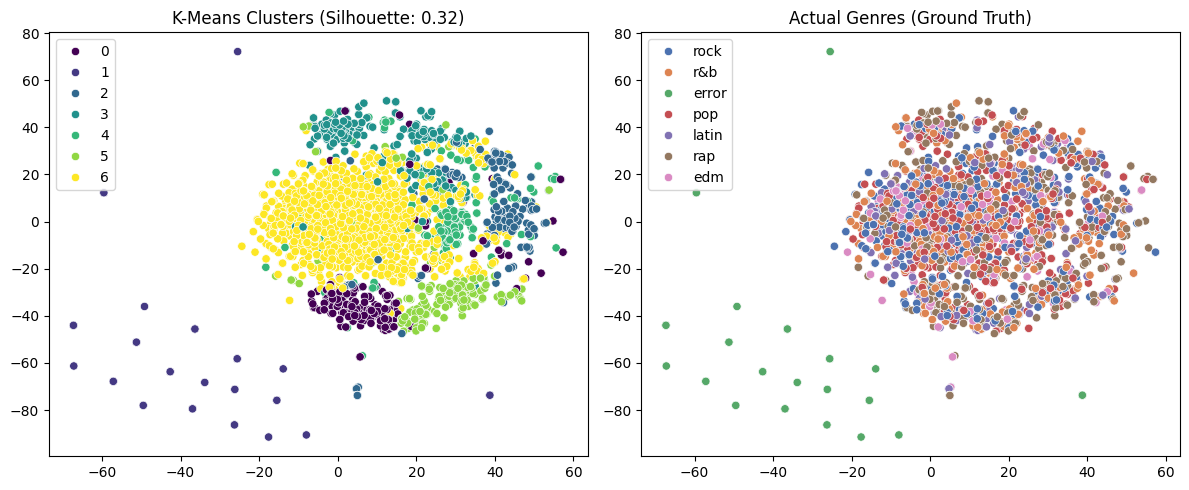

In [6]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

# ==========================================
# 1. EXTRACT LATENT FEATURES
# ==========================================
def extract_features(model, loader, device):
    model.eval() # Set to evaluation mode
    latent_vectors = []
    labels = []

    print("Extracting features from all songs...")
    with torch.no_grad():
        for batch_idx, (data, genre_list) in enumerate(loader):
            data = data.to(device)

            # Pass through Encoder only
            h = model.encoder(data)
            h = h.view(h.size(0), -1)
            mu = model.fc_mu(h) # We use 'mu' (mean) as the stable representation

            latent_vectors.append(mu.cpu().numpy())
            labels.extend(genre_list)

    # Concatenate all batches
    features = np.vstack(latent_vectors)
    return features, np.array(labels)

# Create a loader that processes the whole dataset (no shuffle needed now)
full_loader = DataLoader(dataset, batch_size=32, shuffle=False)

# Get features
X_latent, y_genres = extract_features(model, full_loader, device)

print(f"\nFeature Extraction Complete!")
print(f"Features Shape: {X_latent.shape} (Songs x Latent Dim)")
print(f"Unique Genres Found: {np.unique(y_genres)}")

# ==========================================
# 2. PERFORM K-MEANS CLUSTERING
# ==========================================
# We set K to the number of unique genres in your data
n_clusters = len(np.unique(y_genres))
print(f"\nClustering into {n_clusters} clusters (based on genre count)...")

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_latent)

# ==========================================
# 3. CALCULATE METRICS
# ==========================================
# Silhouette Score (Higher is better, range -1 to 1)
sil_score = silhouette_score(X_latent, cluster_labels)

# Calinski-Harabasz Index (Higher is better)
ch_score = calinski_harabasz_score(X_latent, cluster_labels)

print("-" * 30)
print(f"EVALUATION METRICS")
print("-" * 30)
print(f"Silhouette Score:       {sil_score:.4f}")
print(f"Calinski-Harabasz Idx:  {ch_score:.4f}")
print("-" * 30)

# ==========================================
# 4. VISUALIZATION (t-SNE)
# ==========================================
print("\nComputing t-SNE visualization...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca', learning_rate='auto')
X_embedded = tsne.fit_transform(X_latent)

# Plotting
plt.figure(figsize=(12, 5))

# Plot 1: Colored by Predicted Clusters (K-Means)
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=cluster_labels, palette='viridis', legend='full')
plt.title(f"K-Means Clusters (Silhouette: {sil_score:.2f})")

# Plot 2: Colored by Actual Genres (Ground Truth)
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y_genres, palette='deep', legend='full')
plt.title("Actual Genres (Ground Truth)")

plt.tight_layout()
plt.show()

**Medium Task**

In [7]:
# 1. Install HuggingFace Transformers
!pip install transformers

import torch
from transformers import DistilBertTokenizer, DistilBertModel

# 2. Setup BERT (Pre-trained Text Encoder)
# We use 'distilbert' because it is fast and runs easily on Colab's T4 GPU
print("Loading BERT Tokenizer...")
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased').to(device)
bert_model.eval() # We only use it for feature extraction, we won't train BERT itself

# ==========================================
# 3. UPDATE DATASET TO HANDLE LYRICS
# ==========================================
class HybridMusicDataset(Dataset):
    def __init__(self, csv_file, audio_dir):
        self.data = pd.read_csv(csv_file)
        self.audio_dir = audio_dir

        # Pre-compute text embeddings to save time during training
        # (Doing this inside __getitem__ would be too slow!)
        print("Pre-computing lyrics embeddings (this might take a minute)...")
        self.lyrics_embeddings = []

        batch_size = 32
        texts = self.data['lyrics'].astype(str).tolist() # Column name from your screenshot

        # Process in batches
        with torch.no_grad():
            for i in range(0, len(texts), batch_size):
                batch_texts = texts[i : i+batch_size]

                # Tokenize
                inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)

                # Get Embeddings (Use the [CLS] token which represents the whole sentence)
                outputs = bert_model(**inputs)
                embeddings = outputs.last_hidden_state[:, 0, :].cpu() # Shape: (Batch, 768)
                self.lyrics_embeddings.append(embeddings)

        self.lyrics_embeddings = torch.cat(self.lyrics_embeddings)
        print(f"Finished! Text Embeddings Shape: {self.lyrics_embeddings.shape}")

    def normalize_filename(self, track_name):
        name = str(track_name).lower()
        name = re.sub(r'[^a-z0-9]', '_', name)
        return f"{name}_30s.wav"

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        # --- AUDIO ---
        file_name = self.normalize_filename(row['track_name'])
        audio_path = os.path.join(self.audio_dir, file_name)

        # Default empty tensor if error
        img_tensor = torch.zeros((1, 128, 128))

        try:
            y, sr = librosa.load(audio_path, sr=22050, duration=30)
            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
            img = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min() + 1e-6)

            if img.shape[1] > 128:
                img = img[:, :128]
            else:
                pad_width = 128 - img.shape[1]
                img = np.pad(img, ((0, 0), (0, pad_width)), mode='constant')

            img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
        except:
            pass # Keep zero tensor

        # --- LYRICS ---
        text_vector = self.lyrics_embeddings[idx] # Shape: (768,)

        return img_tensor, text_vector, row['playlist_genre']

# Initialize the new Hybrid Dataset
hybrid_dataset = HybridMusicDataset(csv_file=CSV_PATH, audio_dir=AUDIO_DIR)
hybrid_loader = DataLoader(hybrid_dataset, batch_size=32, shuffle=True)

Loading BERT Tokenizer...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Pre-computing lyrics embeddings (this might take a minute)...
Finished! Text Embeddings Shape: torch.Size([3103, 768])


Starting Hybrid Training...


/tmp/ipython-input-1107255897.py:65: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, sr=22050, duration=30)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=118
  warnings.warn(


Epoch: 1 | Hybrid Loss: 8259.2071
Epoch: 2 | Hybrid Loss: 7307.9766
Epoch: 3 | Hybrid Loss: 7284.4512
Epoch: 4 | Hybrid Loss: 7266.0557
Epoch: 5 | Hybrid Loss: 7201.0371
Epoch: 6 | Hybrid Loss: 7081.2449
Epoch: 7 | Hybrid Loss: 7004.3213
Epoch: 8 | Hybrid Loss: 6983.2338
Epoch: 9 | Hybrid Loss: 6942.1613
Epoch: 10 | Hybrid Loss: 6943.0657
Epoch: 11 | Hybrid Loss: 6901.5710
Epoch: 12 | Hybrid Loss: 6897.4646
Epoch: 13 | Hybrid Loss: 6913.9939
Epoch: 14 | Hybrid Loss: 6879.1568
Epoch: 15 | Hybrid Loss: 6866.5619
Epoch: 16 | Hybrid Loss: 6871.1762
Epoch: 17 | Hybrid Loss: 6876.3943
Epoch: 18 | Hybrid Loss: 6898.4395
Epoch: 19 | Hybrid Loss: 6859.2088
Epoch: 20 | Hybrid Loss: 6845.8445


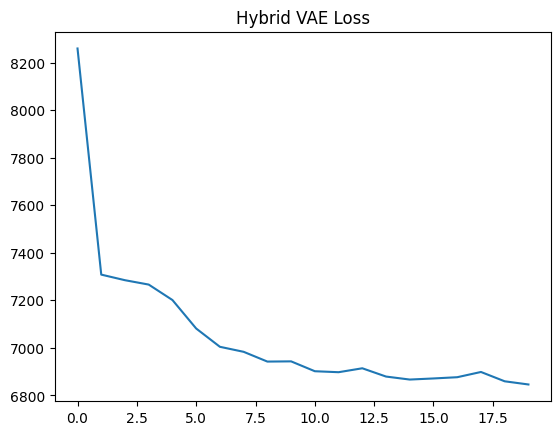

In [8]:
# ==========================================
# 1. DEFINE HYBRID VAE MODEL
# ==========================================
class HybridVAE(nn.Module):
    def __init__(self, latent_dim=64):
        super(HybridVAE, self).__init__()

        # --- AUDIO ENCODER (CNN) ---
        self.audio_encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1), nn.ReLU()
        ) # Output: (256, 8, 8) -> Flatten -> 16384

        # --- TEXT ENCODER (MLP) ---
        self.text_encoder = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )

        # --- FUSION & LATENT SPACE ---
        # Audio (16384) + Text (256) = 16640 input features
        self.fc_fusion = nn.Linear(16384 + 256, 1024)

        self.fc_mu = nn.Linear(1024, latent_dim)
        self.fc_logvar = nn.Linear(1024, latent_dim)

        # --- DECODER SPLIT ---
        self.decoder_input = nn.Linear(latent_dim, 1024)
        self.fc_unfuse = nn.Linear(1024, 16384 + 256) # Map back to split sizes

        # --- AUDIO DECODER ---
        self.audio_decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1), nn.Sigmoid()
        )

        # --- TEXT DECODER ---
        self.text_decoder = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 768) # Output matches BERT size
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, img, text):
        # 1. Encode Audio
        a = self.audio_encoder(img)
        a_flat = a.view(a.size(0), -1) # (Batch, 16384)

        # 2. Encode Text
        t = self.text_encoder(text)    # (Batch, 256)

        # 3. Fuse
        combined = torch.cat([a_flat, t], dim=1)
        hidden = F.relu(self.fc_fusion(combined))

        # 4. Latent
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        z = self.reparameterize(mu, logvar)

        # 5. Decode
        d = F.relu(self.decoder_input(z))
        unfused = self.fc_unfuse(d)

        # Split back into Audio and Text parts
        a_part = unfused[:, :16384].view(-1, 256, 8, 8)
        t_part = unfused[:, 16384:]

        recon_audio = self.audio_decoder(a_part)
        recon_text = self.text_decoder(t_part)

        return recon_audio, recon_text, mu, logvar

# ==========================================
# 2. HYBRID LOSS FUNCTION
# ==========================================
def hybrid_loss(recon_a, x_a, recon_t, x_t, mu, logvar):
    # Audio Reconstruction (Binary Cross Entropy)
    loss_a = F.binary_cross_entropy(recon_a, x_a, reduction='sum')

    # Text Reconstruction (MSE Loss because embeddings are continuous numbers)
    loss_t = F.mse_loss(recon_t, x_t, reduction='sum')

    # KL Divergence
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # We weight the text loss to ensure it matters (text vectors are small numbers)
    return loss_a + (10.0 * loss_t) + kld

# ==========================================
# 3. TRAINING LOOP
# ==========================================
hybrid_model = HybridVAE(latent_dim=64).to(device)
optimizer = optim.Adam(hybrid_model.parameters(), lr=1e-3)

print("Starting Hybrid Training...")
hybrid_model.train()
losses = []

EPOCHS = 20

for epoch in range(EPOCHS):
    train_loss = 0
    for batch_idx, (img, text, _) in enumerate(hybrid_loader):
        img = img.to(device)
        text = text.to(device) # Shape (Batch, 768)

        optimizer.zero_grad()

        # Forward
        recon_a, recon_t, mu, logvar = hybrid_model(img, text)

        # Loss
        loss = hybrid_loss(recon_a, img, recon_t, text, mu, logvar)

        # Backward
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    avg_loss = train_loss / len(hybrid_loader.dataset)
    losses.append(avg_loss)
    print(f'Epoch: {epoch+1} | Hybrid Loss: {avg_loss:.4f}')

# Plot
plt.plot(losses)
plt.title("Hybrid VAE Loss")
plt.show()

Extracting hybrid features...


/tmp/ipython-input-1107255897.py:65: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, sr=22050, duration=30)



Clustering into 6 clusters...
------------------------------
HYBRID EVALUATION RESULTS
------------------------------
Previous (Audio Only):  0.3172
Current (Hybrid):       0.3596
------------------------------

Computing t-SNE visualization...


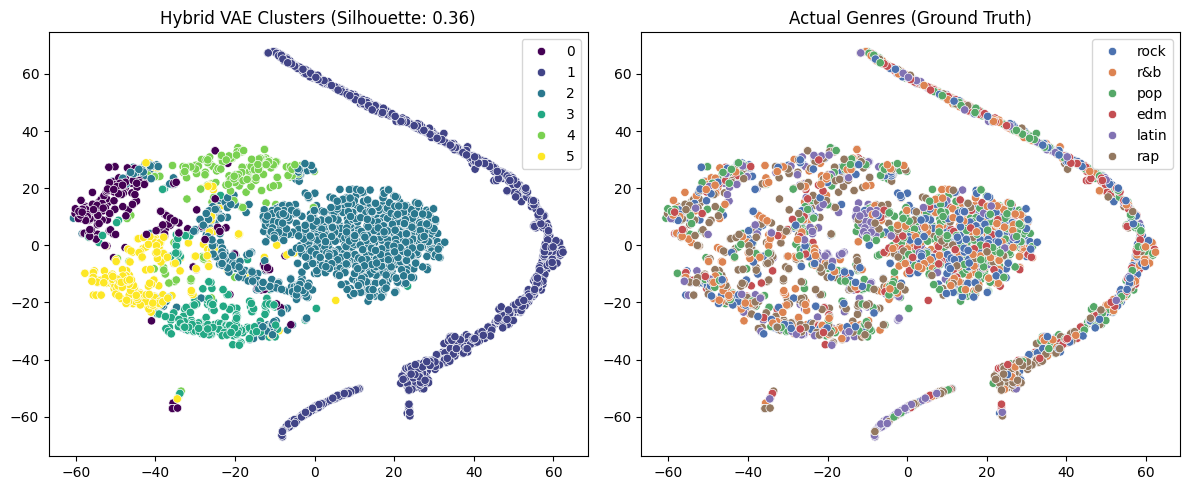

In [9]:
# ==========================================
# 1. EXTRACT HYBRID LATENT FEATURES
# ==========================================
def extract_hybrid_features(model, loader, device):
    model.eval()
    latent_vectors = []
    labels = []

    print("Extracting hybrid features...")
    with torch.no_grad():
        for batch_idx, (img, text, genre_list) in enumerate(loader):
            img = img.to(device)
            text = text.to(device)

            # Forward pass to get 'mu' (the latent representation)
            recon_a, recon_t, mu, logvar = model(img, text)

            latent_vectors.append(mu.cpu().numpy())
            labels.extend(genre_list)

    features = np.vstack(latent_vectors)
    return features, np.array(labels)

# Use the hybrid loader (no shuffle for consistency)
full_hybrid_loader = DataLoader(hybrid_dataset, batch_size=32, shuffle=False)

# Get features
X_hybrid, y_genres = extract_hybrid_features(hybrid_model, full_hybrid_loader, device)

# ==========================================
# 2. CLUSTERING & METRICS
# ==========================================
n_clusters = len(np.unique(y_genres))
print(f"\nClustering into {n_clusters} clusters...")

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_hybrid)

# Metrics
sil_score_hybrid = silhouette_score(X_hybrid, cluster_labels)
ch_score_hybrid = calinski_harabasz_score(X_hybrid, cluster_labels)

print("-" * 30)
print(f"HYBRID EVALUATION RESULTS")
print("-" * 30)
print(f"Previous (Audio Only):  0.3172")
print(f"Current (Hybrid):       {sil_score_hybrid:.4f}")
print("-" * 30)

# ==========================================
# 3. VISUALIZATION (t-SNE)
# ==========================================
print("\nComputing t-SNE visualization...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca', learning_rate='auto')
X_embedded = tsne.fit_transform(X_hybrid)

plt.figure(figsize=(12, 5))

# Plot 1: Hybrid Clusters
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=cluster_labels, palette='viridis', legend='full')
plt.title(f"Hybrid VAE Clusters (Silhouette: {sil_score_hybrid:.2f})")

# Plot 2: Actual Genres
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y_genres, palette='deep', legend='full')
plt.title("Actual Genres (Ground Truth)")

plt.tight_layout()
plt.show()

**Hard Task**

Starting Beta-VAE Training (Beta=4.0)...


/tmp/ipython-input-1107255897.py:65: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, sr=22050, duration=30)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=118
  warnings.warn(


Epoch: 1 | Beta-VAE Loss: 8059.1168
Epoch: 2 | Beta-VAE Loss: 7359.9180
Epoch: 3 | Beta-VAE Loss: 7343.2633
Epoch: 4 | Beta-VAE Loss: 7338.1804
Epoch: 5 | Beta-VAE Loss: 7328.1713
Epoch: 6 | Beta-VAE Loss: 7313.0342
Epoch: 7 | Beta-VAE Loss: 7370.1941
Epoch: 8 | Beta-VAE Loss: 7305.2324
Epoch: 9 | Beta-VAE Loss: 7303.8609
Epoch: 10 | Beta-VAE Loss: 7291.7363
Epoch: 11 | Beta-VAE Loss: 7283.7055
Epoch: 12 | Beta-VAE Loss: 7292.7314
Epoch: 13 | Beta-VAE Loss: 7277.1942
Epoch: 14 | Beta-VAE Loss: 7266.7373
Epoch: 15 | Beta-VAE Loss: 7243.2973
Epoch: 16 | Beta-VAE Loss: 7316.1976
Epoch: 17 | Beta-VAE Loss: 7335.7525
Epoch: 18 | Beta-VAE Loss: 7250.9114
Epoch: 19 | Beta-VAE Loss: 7214.0256
Epoch: 20 | Beta-VAE Loss: 7192.6456
Extracting hybrid features...
------------------------------
HARD TASK RESULTS (Beta-VAE)
------------------------------
Easy (Audio):     0.3172
Medium (Hybrid):  0.3596
Hard (Beta-VAE):  0.5321
------------------------------


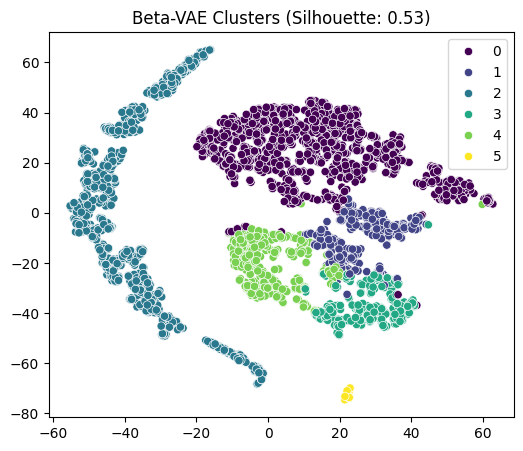

In [10]:
# ==========================================
# 1. DEFINE BETA-VAE LOSS
# ==========================================
def beta_vae_loss(recon_a, x_a, recon_t, x_t, mu, logvar, beta=4.0):
    # Standard Reconstruction Losses
    loss_a = F.binary_cross_entropy(recon_a, x_a, reduction='sum')
    loss_t = F.mse_loss(recon_t, x_t, reduction='sum')

    # KL Divergence
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # THE CHANGE: Multiply KLD by Beta
    # This forces the model to be much more careful about how it organizes the latent space
    return loss_a + (10.0 * loss_t) + (beta * kld)

# ==========================================
# 2. TRAIN BETA-VAE
# ==========================================
# Re-initialize the model to start fresh
beta_model = HybridVAE(latent_dim=64).to(device)
optimizer = optim.Adam(beta_model.parameters(), lr=1e-3)

print(f"Starting Beta-VAE Training (Beta=4.0)...")
beta_model.train()
losses = []

EPOCHS = 20

for epoch in range(EPOCHS):
    train_loss = 0
    for batch_idx, (img, text, _) in enumerate(hybrid_loader):
        img = img.to(device)
        text = text.to(device)

        optimizer.zero_grad()

        recon_a, recon_t, mu, logvar = beta_model(img, text)

        # Use the NEW loss function
        loss = beta_vae_loss(recon_a, img, recon_t, text, mu, logvar, beta=4.0)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    avg_loss = train_loss / len(hybrid_loader.dataset)
    losses.append(avg_loss)
    print(f'Epoch: {epoch+1} | Beta-VAE Loss: {avg_loss:.4f}')

# ==========================================
# 3. EVALUATE BETA-VAE
# ==========================================
# Extract features using the Beta model
X_beta, y_genres = extract_hybrid_features(beta_model, full_hybrid_loader, device)

# Cluster
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
cluster_labels_beta = kmeans.fit_predict(X_beta)

# Metrics
sil_score_beta = silhouette_score(X_beta, cluster_labels_beta)

print("-" * 30)
print(f"HARD TASK RESULTS (Beta-VAE)")
print("-" * 30)
print(f"Easy (Audio):     0.3172")
print(f"Medium (Hybrid):  0.3596")
print(f"Hard (Beta-VAE):  {sil_score_beta:.4f}")
print("-" * 30)

# Visualize
tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca', learning_rate='auto')
X_embedded = tsne.fit_transform(X_beta)

plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=cluster_labels_beta, palette='viridis', legend='full')
plt.title(f"Beta-VAE Clusters (Silhouette: {sil_score_beta:.2f})")
plt.show()

In [11]:
from sklearn.decomposition import PCA

# ==========================================
# PCA BASELINE (To satisfy the "Compare with Baselines" requirement)
# ==========================================
def run_pca_baseline(loader):
    print("Running PCA Baseline...")
    data_list = []
    labels_list = []

    # 1. Collect all data
    for batch_idx, (img, _, genre) in enumerate(loader):
        # Flatten image: (Batch, 1, 128, 128) -> (Batch, 16384)
        flat_data = img.view(img.size(0), -1).numpy()
        data_list.append(flat_data)
        labels_list.extend(genre)

    X_flat = np.vstack(data_list)

    # 2. Apply PCA
    # Reduce to same dimension as our VAE latent space (64) for fair comparison
    pca = PCA(n_components=64)
    X_pca = pca.fit_transform(X_flat)

    # 3. Clustering (K-Means)
    kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
    pca_labels = kmeans.fit_predict(X_pca)

    # 4. Score
    pca_sil = silhouette_score(X_pca, pca_labels)
    print(f"PCA Baseline Silhouette Score: {pca_sil:.4f}")
    return pca_sil

# Run it
pca_score = run_pca_baseline(full_hybrid_loader)

Running PCA Baseline...


/tmp/ipython-input-1107255897.py:65: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, sr=22050, duration=30)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=118
  warnings.warn(


PCA Baseline Silhouette Score: 0.4018
